In [1]:
import flax
from flax import linen as nn
from flax.core import unfreeze

import jax
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
import seaborn as sns
import distrax
# from datasets import cos_normal_noise
import tensorflow_probability.substrates.jax as tfp

# from models import mc_dropout
# from utils import fit

In [2]:
import regdata as rd

In [3]:
mc = rd.SineNoisy()
X, Y = mc.X, mc.y

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='X', ylabel='y'>)

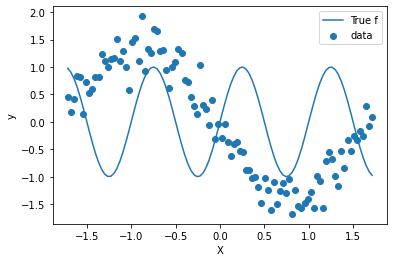

In [4]:
mc.plot()

In [5]:
1# Generate dataset and grid
key, subkey = jax.random.split(jax.random.PRNGKey(0))
X = jax.random.uniform(key, shape=(100, 1), minval=0.0, maxval=0.5)
x_grid = jnp.linspace(0, 0.5, 100).reshape(-1, 1)

# Define function
def target_toy(key, x):
    epsilons = jax.random.normal(key, shape=(3,)) * 0.02
    return (
        x + 0.3 * jnp.sin(2 * jnp.pi * (x + epsilons[0])) + 0.3 * jnp.sin(4 * jnp.pi * (x + epsilons[1])) + epsilons[2]
    )


# Define vectorized version of function
target_vmap = jax.vmap(target_toy, in_axes=(0, 0), out_axes=0)

# Generate target values
keys = jax.random.split(subkey, X.shape[0])
Y = target_vmap(keys, X)

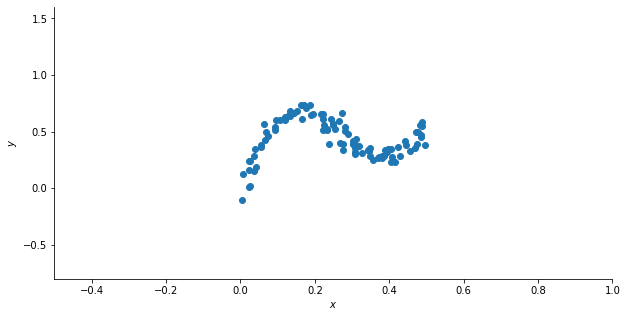

In [6]:
plt.figure(figsize=(10,5))
plt.scatter(X,Y)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-0.5, 1.0)
plt.ylim(-0.8, 1.6)
sns.despine()
plt.show()

In [173]:
dist = tfp.distributions
class gmlp(nn.Module):
    features : list
        
    @nn.compact
    def __call__(self, X, dropout, rate = 0.03):
        
        for i, feature in enumerate(self.features):
            X = nn.Dense(feature, kernel_init=jax.nn.initializers.glorot_normal(), name=f"Dense_{i}")(X)
            X = nn.relu(X)
            if i != 0:
                X = nn.Dropout(rate=rate, deterministic=dropout, name=f"Dense_{i}_dropout")(X)
            
        X = nn.Dense(2, name=f"Dense_{i+1}")(X)
        mean = X[:,0]
        sigma = nn.softplus(X[:,1])
        return mean, sigma
    

    def loss_fn(self, params, X, y, dropout=False, rate=0.03, rng=jax.random.PRNGKey(0)):
        mean, sigma = self.apply(params, X, dropout=dropout, rngs={"dropout":rng})
        def loss(params, mean, sigma, y):
            d = dist.Normal(loc=mean, scale=sigma)
            return -d.log_prob(y)
        return jnp.mean(jax.vmap(loss, in_axes=(None, 0, 0, 0))(params, mean, sigma, y))
    


In [247]:
def fit(model, params, X, y, dropout, learning_rate = 0.01, epochs=1000, verbose=False):
    
    opt = optax.adam(learning_rate=learning_rate)
    opt_state = opt.init(params)

    loss_grad_fn = jax.jit(jax.value_and_grad(model.loss_fn))
    losses = []
    rng = jax.random.PRNGKey(0)
    for i in range(epochs):
        _, rng = jax.random.split(rng)
        loss_val, grads = loss_grad_fn(params, X, y)
        updates, opt_state = opt.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        losses.append(loss_val)
        if verbose and i % (epochs / 10) == 0:
            print('Loss step {}: '.format(i), loss_val)
    return params, jnp.array(losses)

In [272]:
model = gmlp([16, 32])

In [273]:
params = model.init(jax.random.PRNGKey(0), X, True)

In [274]:
params, loss = fit(model, params, X, Y, dropout = False, learning_rate=0.03, epochs=2000, verbose=True)

Loss step 0:  0.7549114
Loss step 200:  -0.9233413
Loss step 400:  -1.0074524
Loss step 600:  -1.1507295
Loss step 800:  -1.1868368
Loss step 1000:  -1.2813439
Loss step 1200:  -1.1500641
Loss step 1400:  -1.41673
Loss step 1600:  -1.4562677
Loss step 1800:  -1.4795123


In [275]:
x = jnp.linspace(0,0.5,100).reshape((-1,1))

In [276]:
# mean, sigma = model.apply(params, X, dropout=True)
y_hat = model.apply(params, x, True)

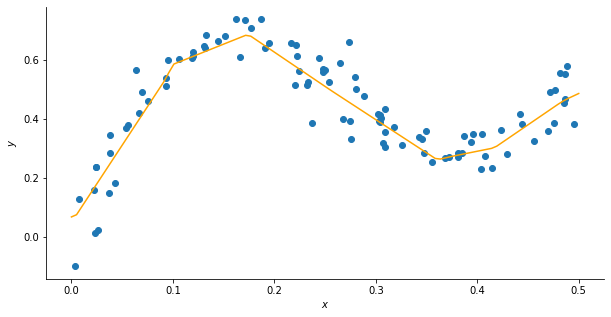

In [277]:
plt.figure(figsize=(10,5))
plt.scatter(X, Y)
plt.plot(x, y_hat[0], color="orange")
plt.xlabel("$x$")
plt.ylabel("$y$")
sns.despine()
plt.show()

In [282]:
x = jnp.linspace(-0.5, 1, 200).reshape(-1,1)
n_stacks = 100
mean_stacks = []
sigma_stacks = []
for i in range(n_stacks):
    y_stack = model.apply(params, x, dropout=False, rate = 0.1, rngs={"dropout": jax.random.PRNGKey(i)})
    mean_stacks.append(y_stack[0])
    sigma_stacks.append(y_stack[1])

In [283]:
mean_stacks = jnp.array(mean_stacks)
sigma_stacks = jnp.array(sigma_stacks)

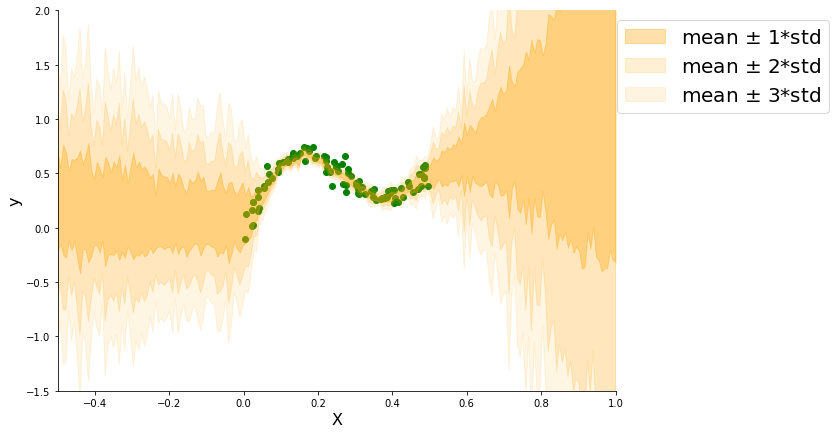

In [284]:
plt.figure(figsize=(10,7))
plt.scatter(X, Y, c="g")

mean = (mean_stacks.mean(axis=0)).squeeze()
std = (sigma_stacks.std(axis=0)).squeeze()

for i in range(1,4):
    plt.fill_between(x.squeeze(), mean - i*std, mean + i*std, color="orange", alpha = 1/(i*3), label = f"mean $\pm$ {i}*std")
plt.legend(bbox_to_anchor=(1.4,1), fontsize=20)
sns.despine()
plt.xlabel("X",fontsize=16)
plt.ylabel("y",fontsize=16)
# plt.xlim(-10,10)
plt.xlim(-0.5, 1.0)
plt.ylim(-1.5, 2)
plt.savefig("guassin_mlp_dropout1.pdf",bbox_inches="tight")